# Modèle de Détection de Langue

Ce projet est un modèle de détection de la langue d'un texte basé sur un modèle d'apprentissage automatique. Il utilise un modèle régression logistique comme algorithme principal pré-entraîné pour prédire la langue du texte en entrée.

Télécharger les données et extraire l'archive.

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import unidecode
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

#### Charger les commentaires dans un dataframe pandas.

In [6]:
!pip install unidecode

In [7]:
def load_commentaires(folder_path):
    data = pd.read_csv(folder_path)
    return data

In [8]:
#recuperer tous les commentaires
lg_detection = load_commentaires('LanguageDetection.csv')

In [9]:
lg_detection

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada


Afficher deux critiques positives et deux critiques négatives. Le texte a t-il besoin de prétraitrement ? Lesquels. 

#### Nettoyage des commentaires : 
- enlever la ponctuaction et les caractères spéciaux
- enlever les stopwords
- lemmatisation

Importer spacy et charger le modèle de langue anglaise

In [10]:
import spacy
nlp = spacy.load('fr_core_news_sm')

Créer une fonction permettant de nettoyer le texte

In [11]:
# def nettoyage_texte(texte):
#     spacy_text = nlp(texte)
#     text_token = [w.text for w in spacy_text if w.is_alpha and not w.is_stop]
#     return " ".join(text_token)

In [12]:
def preprocess_multilang(text):
    text = text.lower()   
    
    # Supprimer la ponctuation en conservant les caractères spéciaux et les accents
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
    # Remplacer les séquences de blancs par un seul espace
    text = re.sub(r'\s+', ' ', text)
    
        # Supprimer les accents
    text = unidecode.unidecode(text)
    # Supprimer les chiffres si nécessaire
    # text = re.sub(r'\d+', '', text)
    
    return text.strip()


Appliquer le nettoyage sur l'ensemble des commentaires du dataframe. Cette étape prend un peu (beaucoup) de temps, c'est normal!

In [13]:
clean_data = lg_detection.copy()
clean_data['text'] = lg_detection['Text'].apply(preprocess_multilang)

In [14]:
print(clean_data.head(25))

                                                 Text Language  \
0    Nature, in the broadest sense, is the natural...  English   
1   "Nature" can refer to the phenomena of the phy...  English   
2   The study of nature is a large, if not the onl...  English   
3   Although humans are part of nature, human acti...  English   
4   [1] The word nature is borrowed from the Old F...  English   
5   [2] In ancient philosophy, natura is mostly us...  English   
6   [3][4] \nThe concept of nature as a whole, the...  English   
7   During the advent of modern scientific method ...  English   
8   [5][6] With the Industrial revolution, nature ...  English   
9   However, a vitalist vision of nature, closer t...  English   
10  [1] Within the various uses of the word today,...  English   
11  Nature can refer to the general realm of livin...  English   
12  It is often taken to mean the "natural environ...  English   
13  For example, manufactured objects and human in...  English   
14  This m

In [15]:
clean_data

,Text,Language,text
0,"Nature, in the broadest sense, is the natural...",English,nature in the broadest sense is the natural ph...
1,"""Nature"" can refer to the phenomena of the phy...",English,nature can refer to the phenomena of the physi...
2,"The study of nature is a large, if not the onl...",English,the study of nature is a large if not the only...
3,"Although humans are part of nature, human acti...",English,although humans are part of nature human activ...
4,[1] The word nature is borrowed from the Old F...,English,1 the word nature is borrowed from the old fre...
...,...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada,nimm tppu eenu bNdideyeNdre aa dindiNd nimge o...
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada,naarsisaa taanu modlige henngaadduttidd maargg...
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada,heege naarsisism iig mriyn avrige sNbhvisid el...
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada,avllu iig heccu cinnd bredd bysuvudill eNdu na...


#### Analyse des commentaires
- Afficher des nuage de mots pour les commentaires positifs et négatifs.

In [16]:
clean_data.groupby('Language').count()

,Text,text
Language,,
Arabic,536,536
Danish,428,428
Dutch,546,546
English,1385,1385
French,1014,1014
German,470,470
Greek,365,365
Hindi,63,63
Italian,698,698


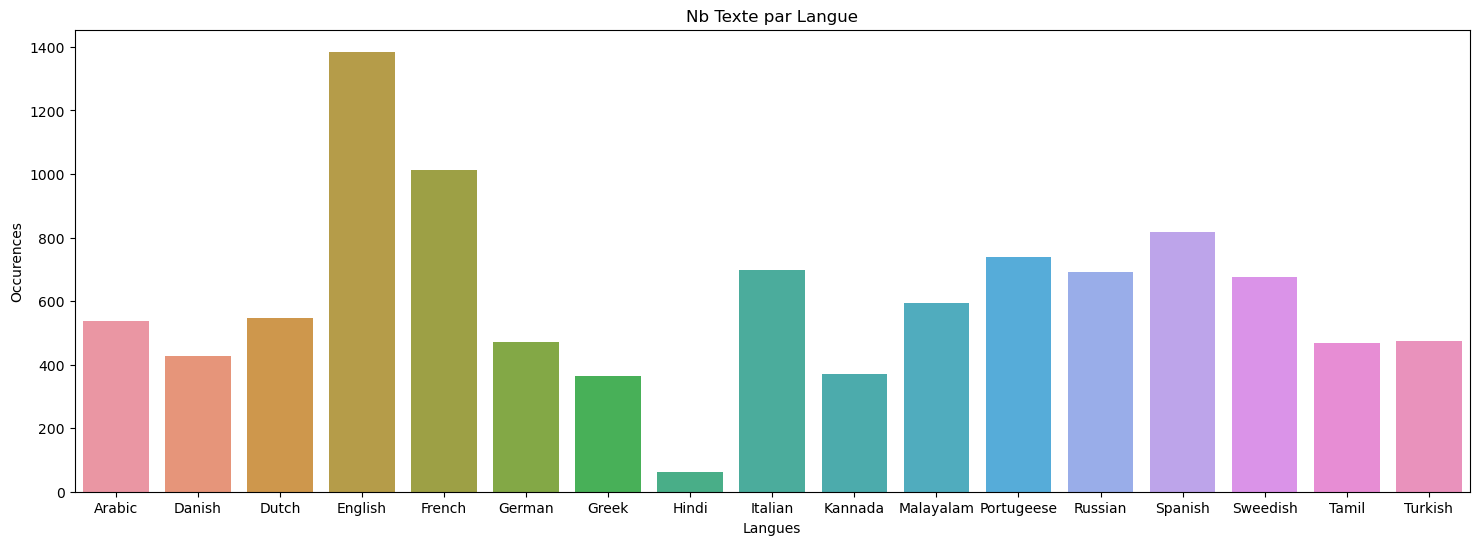

In [17]:
x = clean_data.groupby('Language').count().reset_index()
plt.figure(figsize=(18,6))
ax= sns.barplot(x, x="Language", y="text")
plt.title("Nb Texte par Langue")
plt.xlabel('Langues')
plt.ylabel('Occurences')

plt.show()

Nuage de mots pour la langue : Arabic


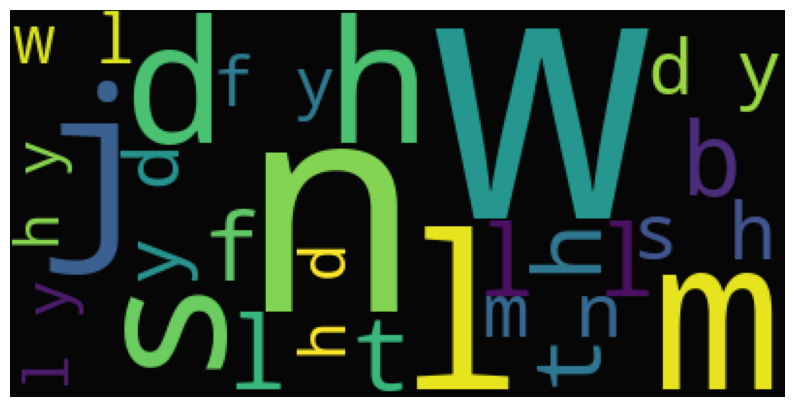

Nuage de mots pour la langue : Danish


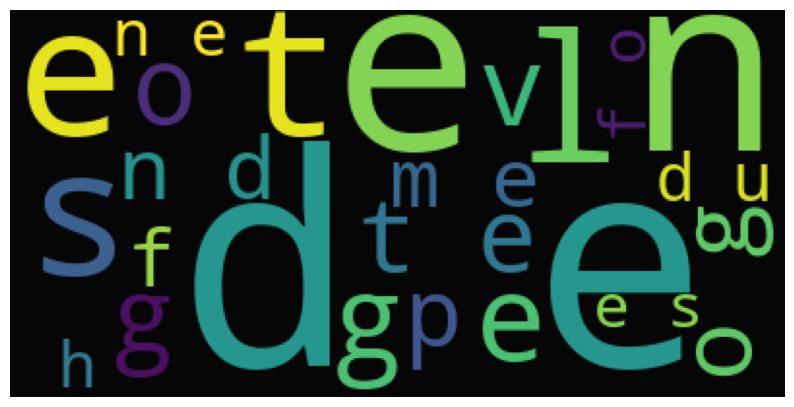

Nuage de mots pour la langue : Dutch


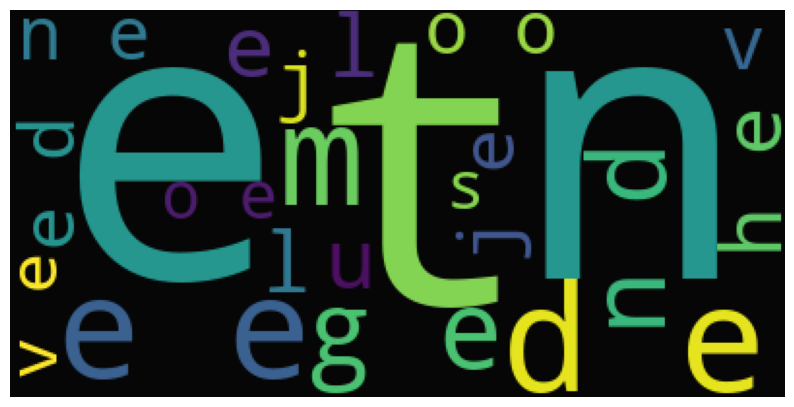

Nuage de mots pour la langue : English


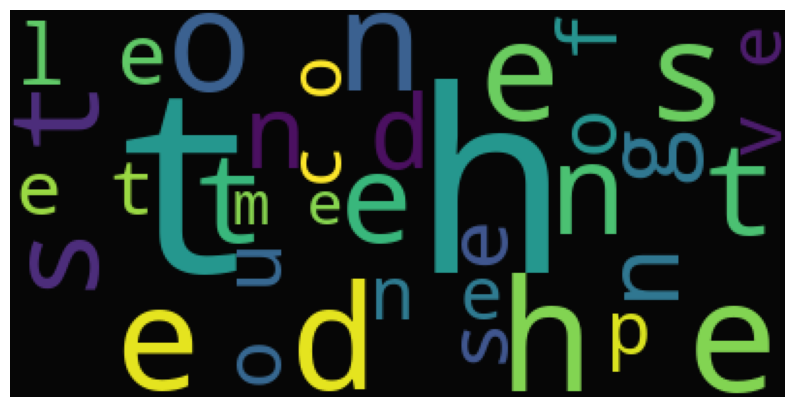

Nuage de mots pour la langue : French


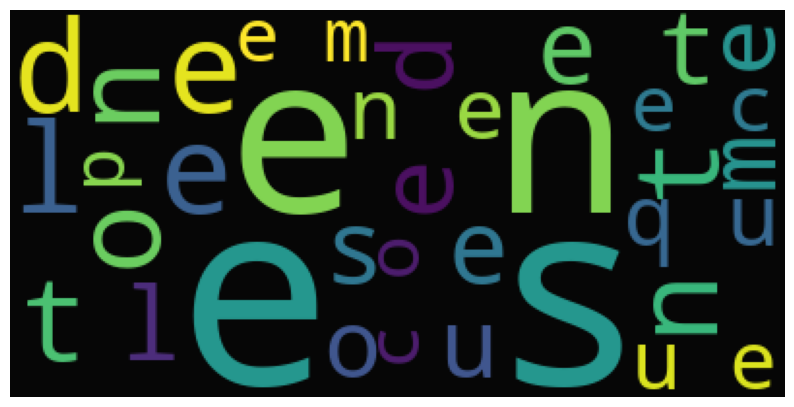

Nuage de mots pour la langue : German


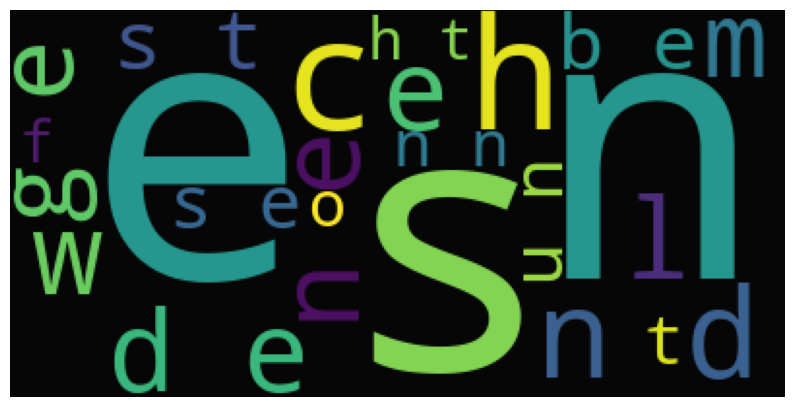

Nuage de mots pour la langue : Greek


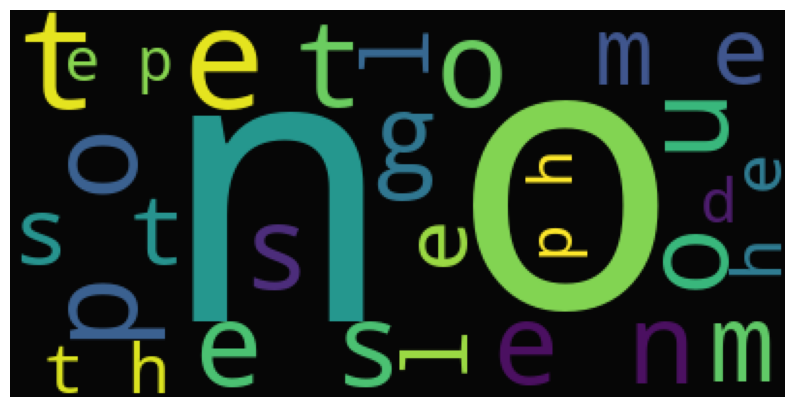

Nuage de mots pour la langue : Hindi


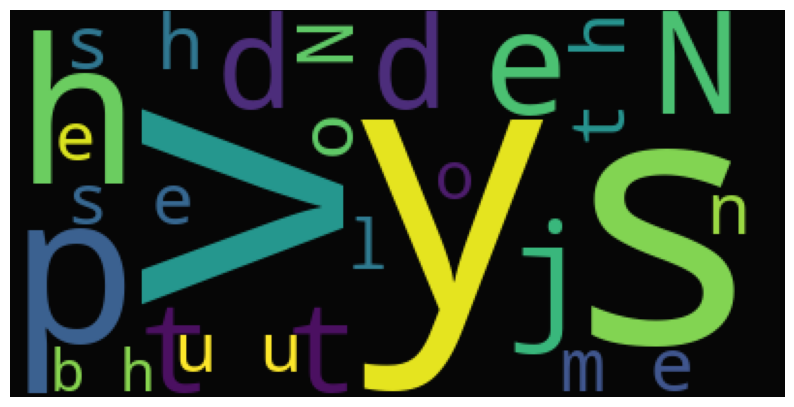

Nuage de mots pour la langue : Italian


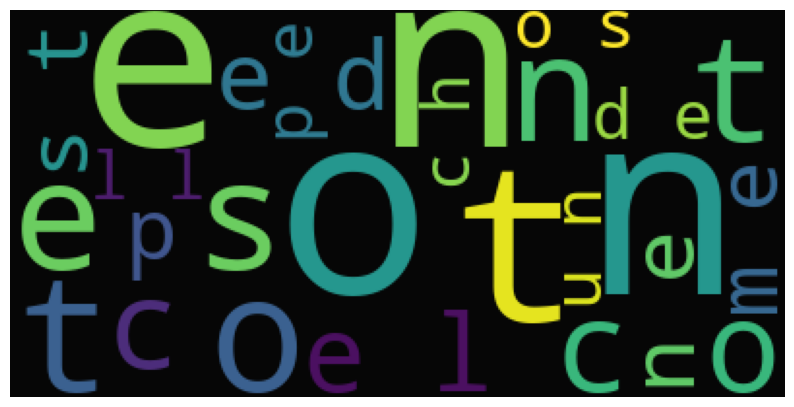

Nuage de mots pour la langue : Kannada


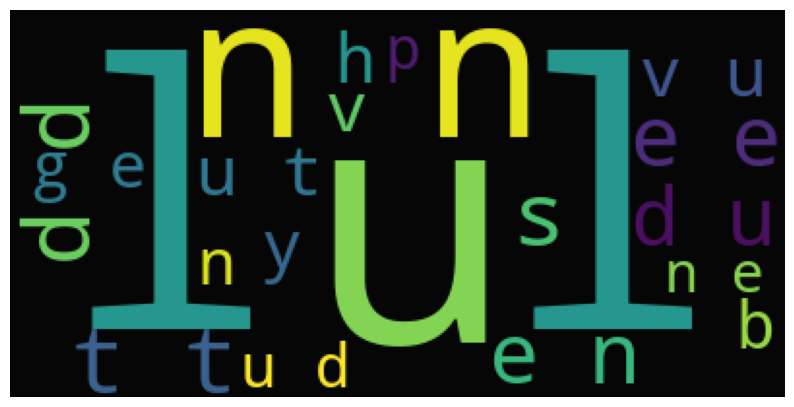

Nuage de mots pour la langue : Malayalam


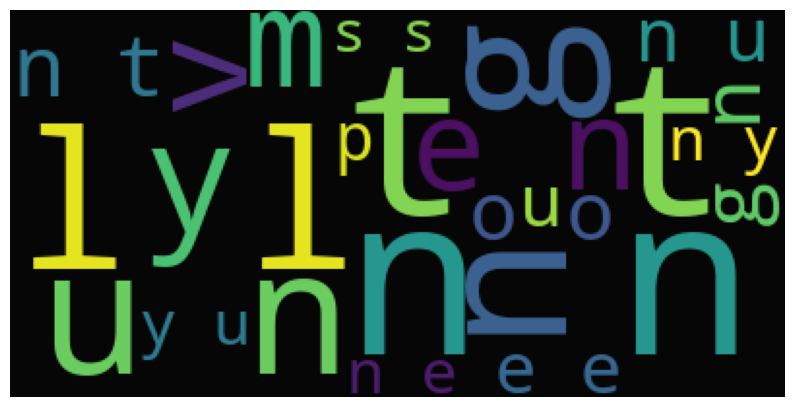

Nuage de mots pour la langue : Portugeese


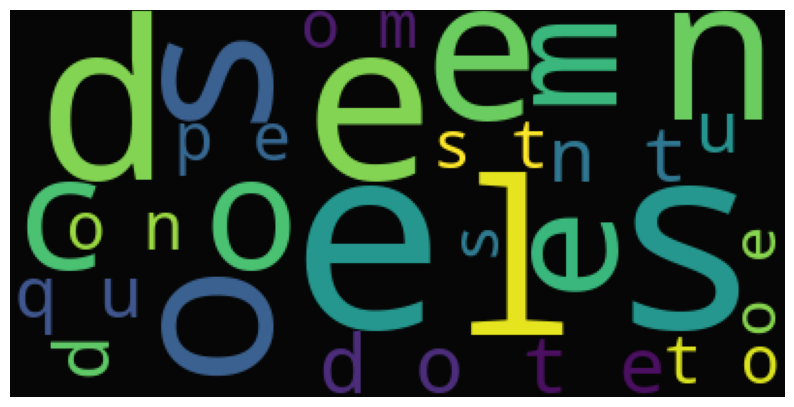

Nuage de mots pour la langue : Russian


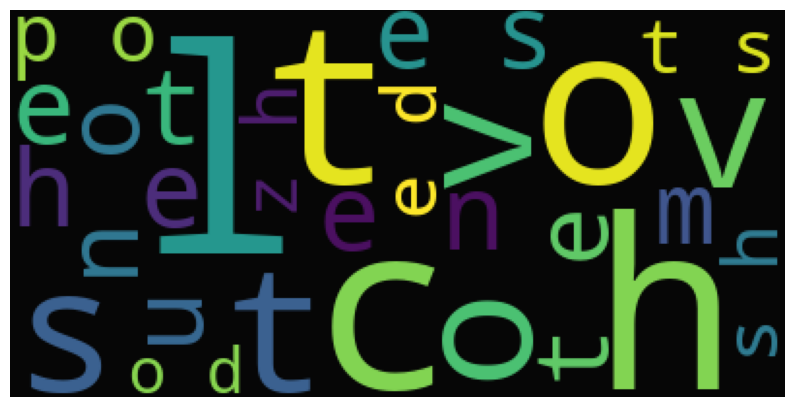

Nuage de mots pour la langue : Spanish


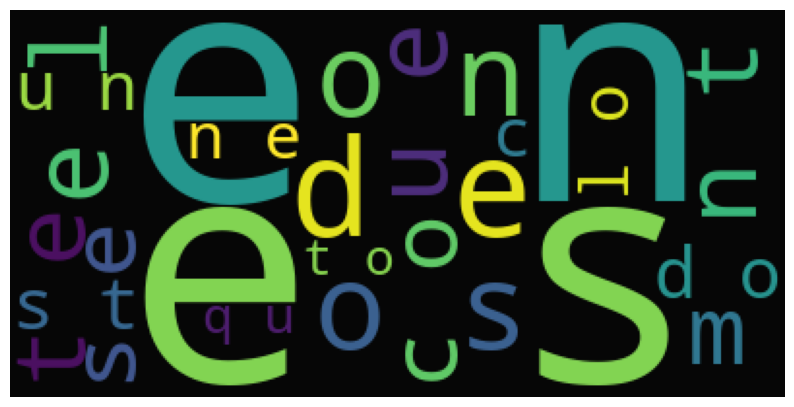

Nuage de mots pour la langue : Sweedish


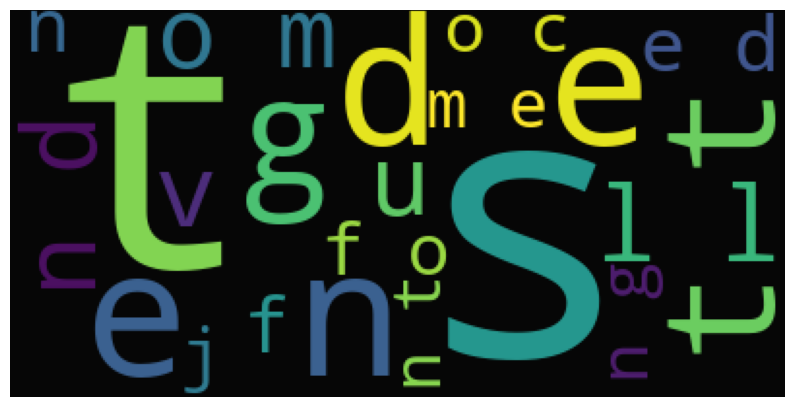

Nuage de mots pour la langue : Tamil


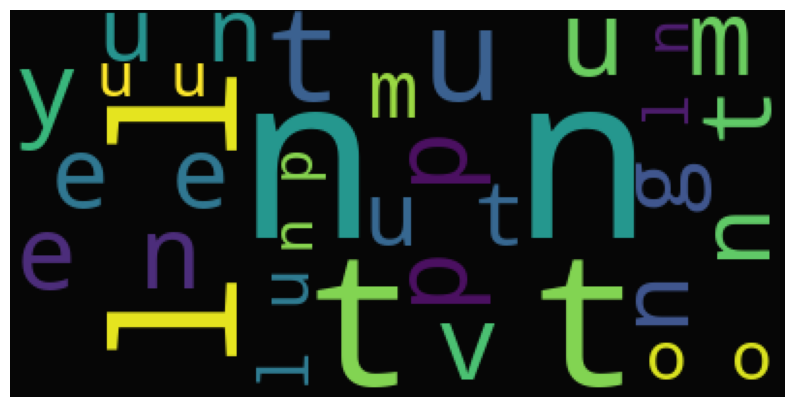

Nuage de mots pour la langue : Turkish


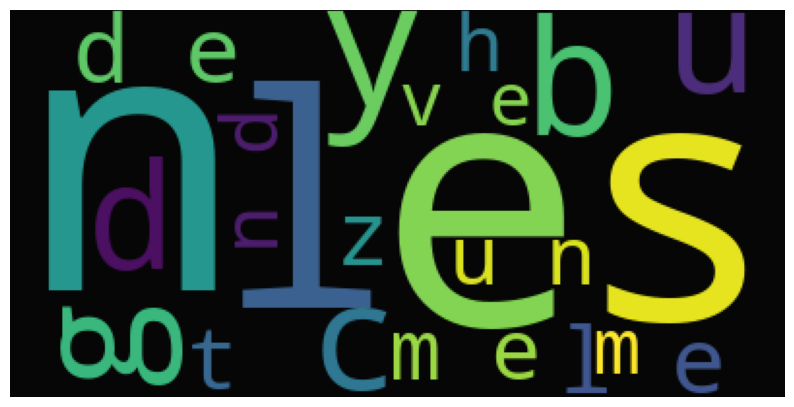

In [18]:
texts_by_language = {}
for language, group in clean_data.groupby('Language'):
    texts_by_language[language] = ' '.join(group['text'])


for language, text in texts_by_language.items():
    print(f"Nuage de mots pour la langue : {language}")
    wc=WordCloud(background_color="black",max_words=20)
    wc.generate(" ".join(text))
    plt.figure(figsize=(10,8))
    plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
    plt.axis('off')
    plt.show()  

#### Vectorisation des commentaires : 
Transformer les commentaires en vecteurs numériques admissible par un algorithme de machine learning.
On va utiliser le vectoriseur Tf-Idf (cf glossaire NLP)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
Tvectorizer = TfidfVectorizer()
X = Tvectorizer.fit_transform(clean_data['text'])
Y = clean_data['Language']

In [65]:
X.shape

(10337, 44733)

In [66]:
print(X[2])

  (0, 34258)	0.31644442415543633
  (0, 28235)	0.3115467939299389
  (0, 27168)	0.31393279135633567
  (0, 26232)	0.2680638595581029
  (0, 16767)	0.28468157375788733
  (0, 20947)	0.3457949342043214
  (0, 37079)	0.3280676349894067
  (0, 26821)	0.34807322776402005
  (0, 18109)	0.19397159070056105
  (0, 38535)	0.3313738757516431
  (0, 25328)	0.23570063177922926


In [67]:
print(Y)

0        English
1        English
2        English
3        English
4        English
          ...   
10332    Kannada
10333    Kannada
10334    Kannada
10335    Kannada
10336    Kannada
Name: Language, Length: 10337, dtype: object


#### Analyse des commentaires vectorisés
- Afficher des graphiques en barre montarant les 10 mots ayant le plus de poids dans les commentaires positifs et négatifs.

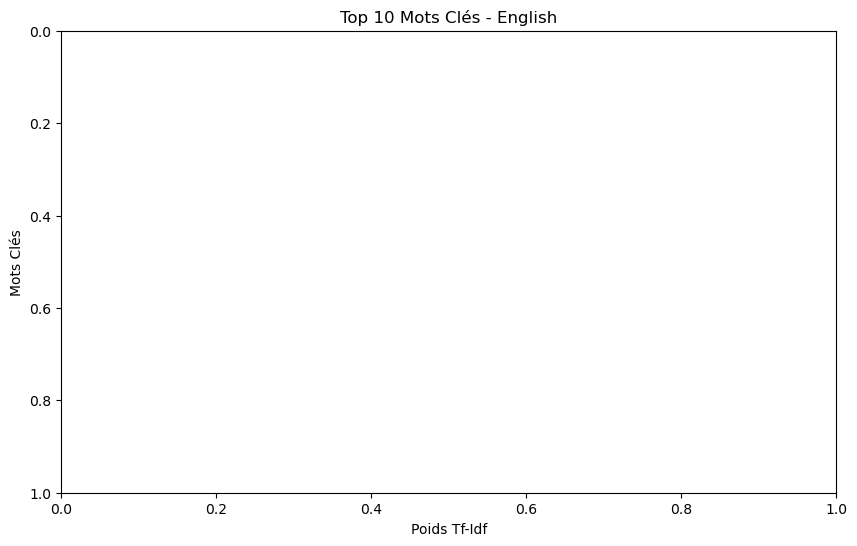

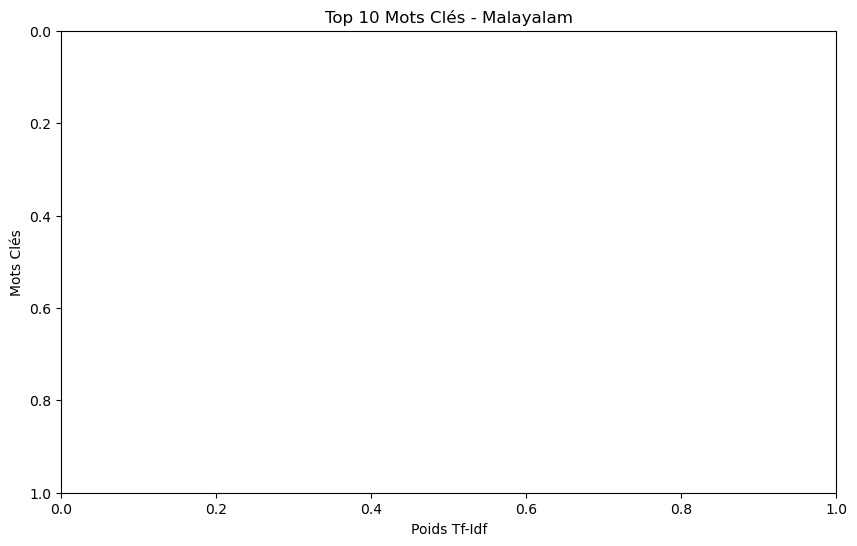

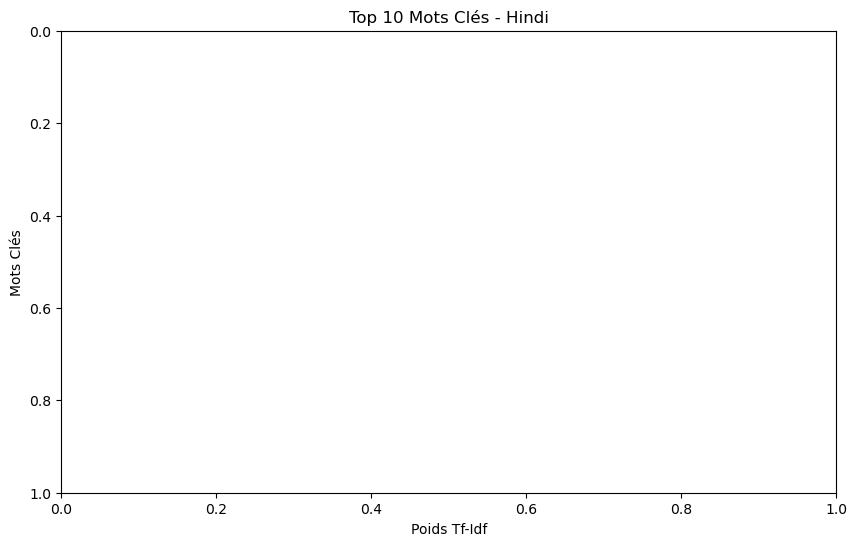

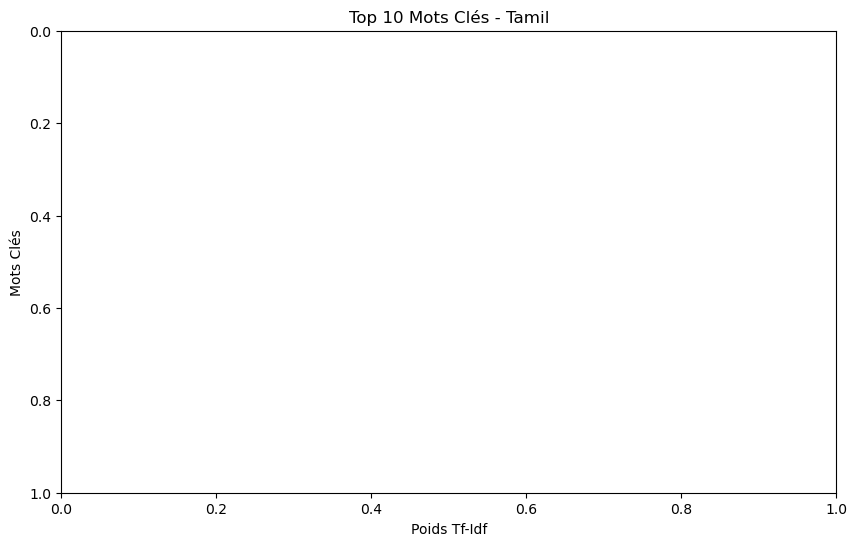

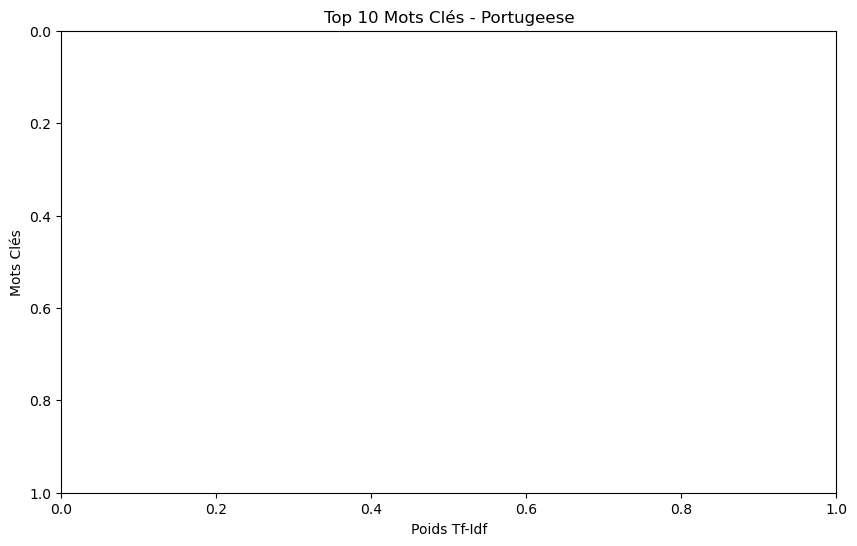

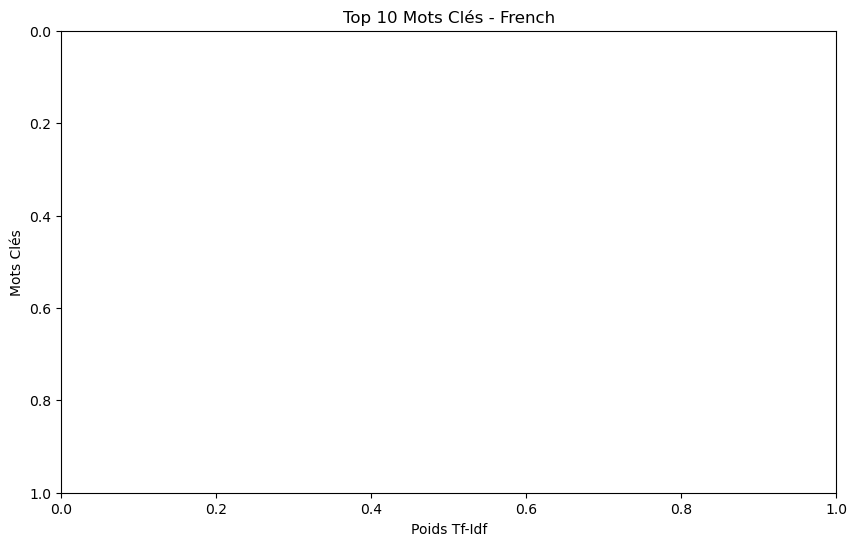

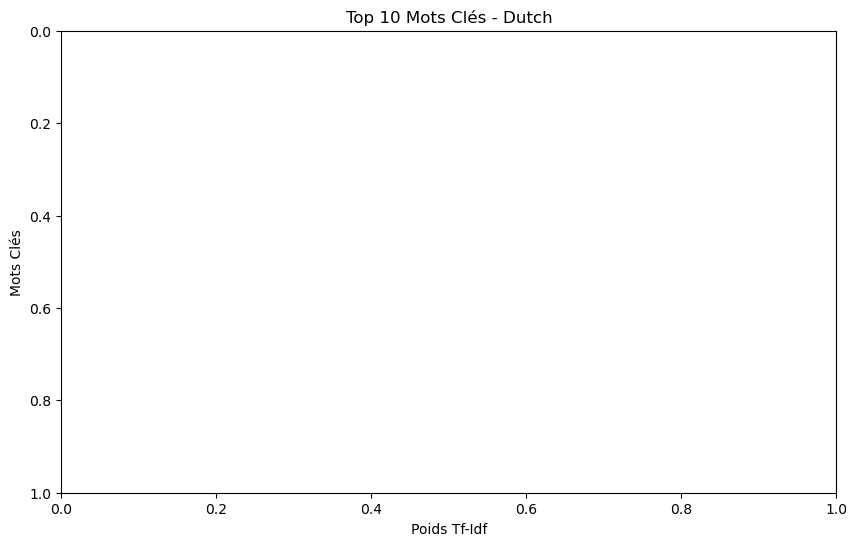

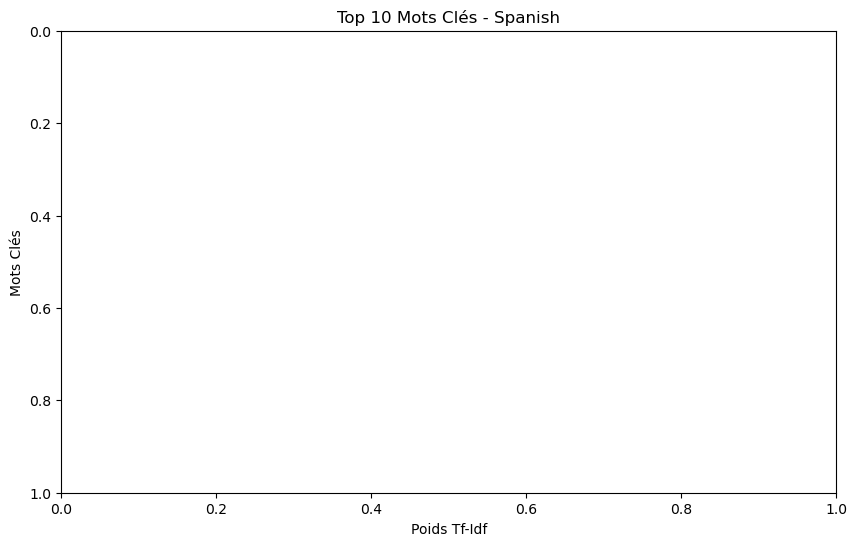

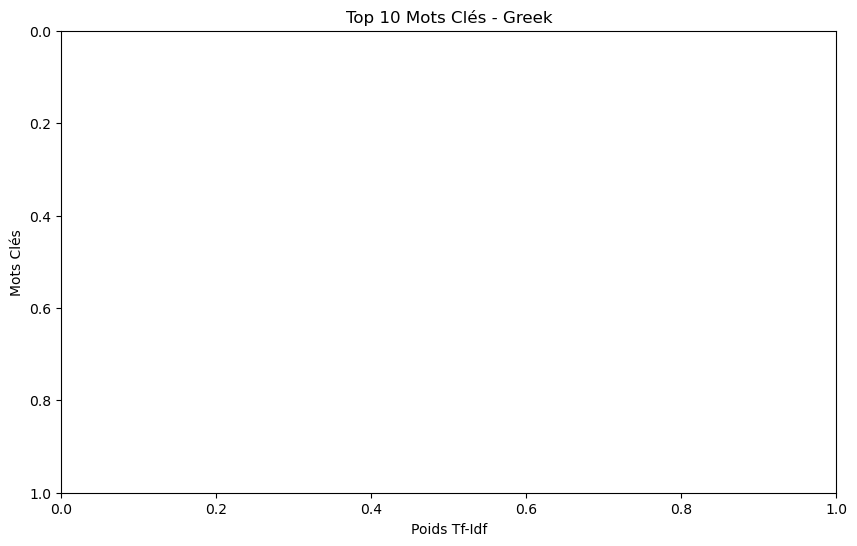

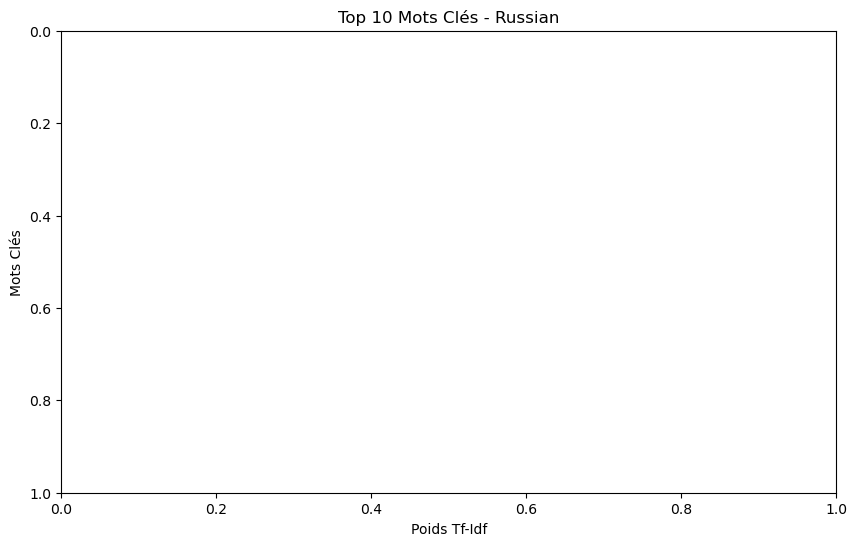

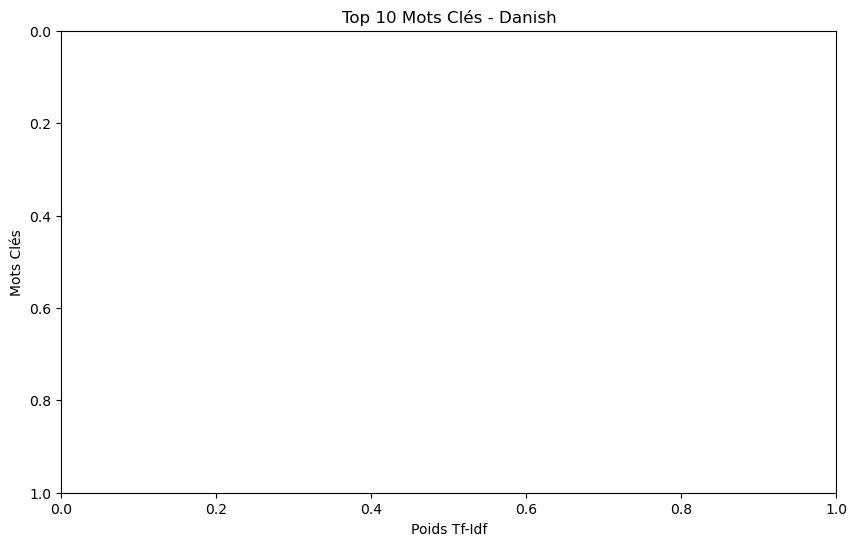

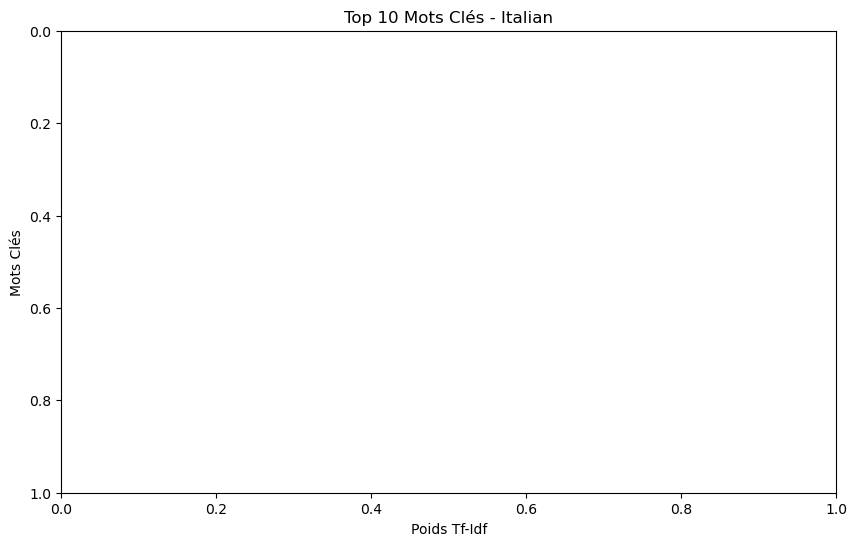

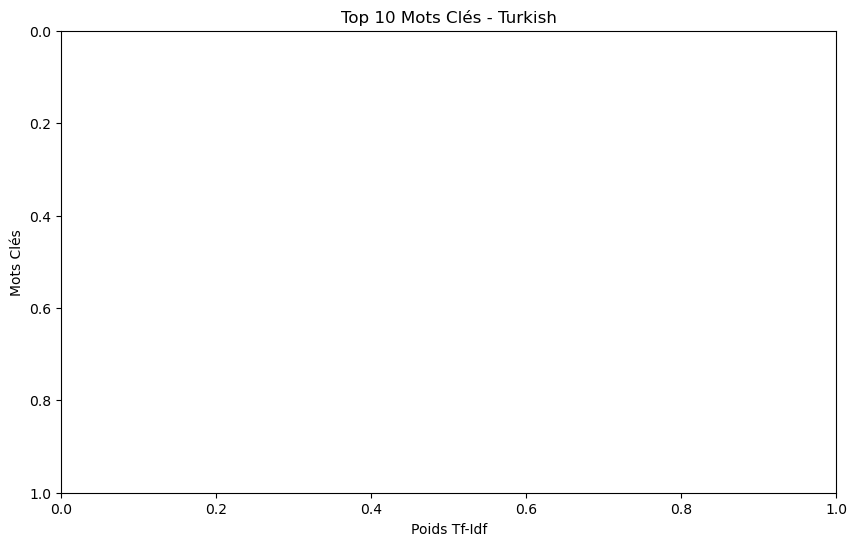

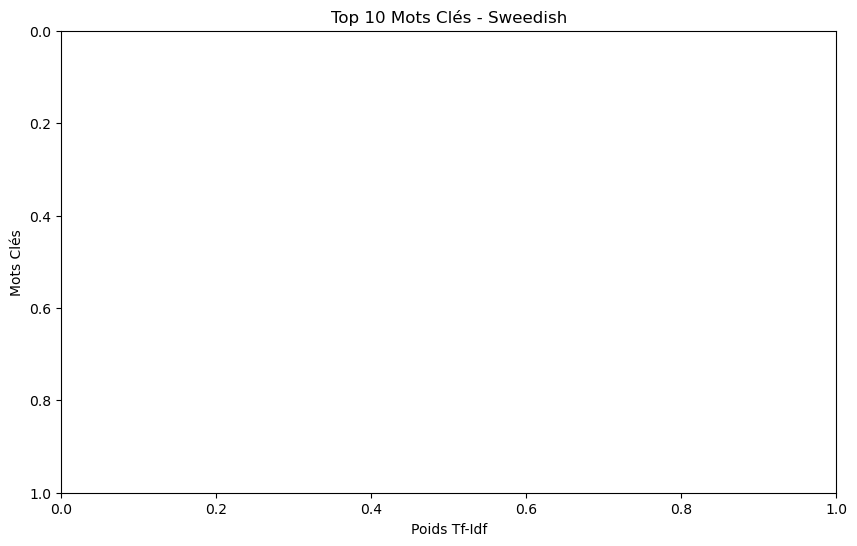

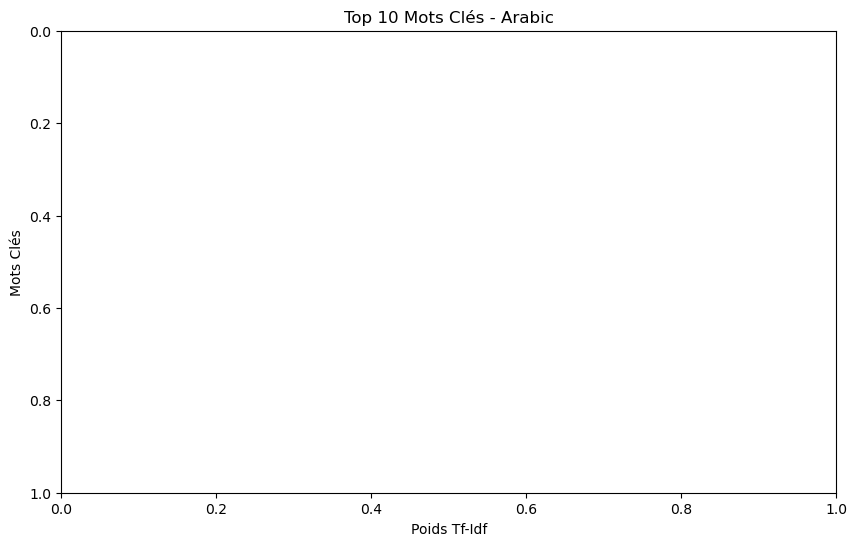

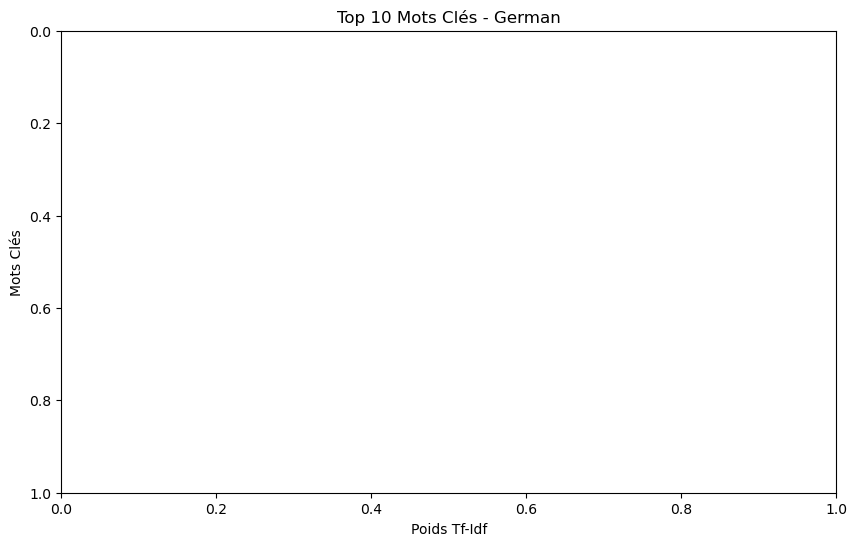

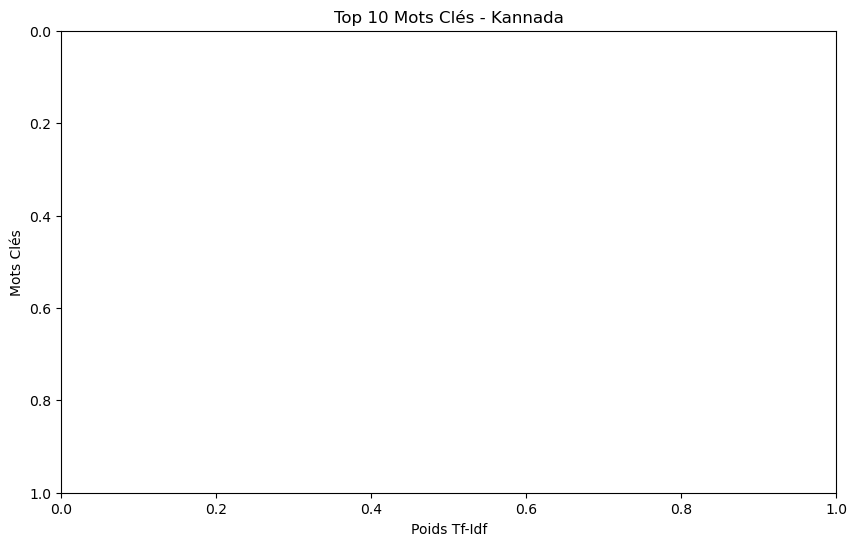

In [61]:
top_words_by_language = {}
vectorizer = TfidfVectorizer()

# Parcourez chaque langue
for language in clean_data['Language'].unique():
    
    language_data = clean_data[clean_data['Language'] == language]['text']
    
    tfidf_matrix = vectorizer.fit_transform(language_data)
    
    feature_names = vectorizer.get_feature_names_out()
    
    # Obtenir les indices des mots ayant les valeurs les plus élevées
    top_word_indices = tfidf_matrix.sum(axis=0).argsort()[0, ::-1][:10]
    
    # Obtenir les mots correspondants
    top_words = [feature_names[i] for i in top_word_indices]
    
    # Stocker les mots dans le dictionnaire
    top_words_by_language[language] = top_words

# Créer les graphiques en barre pour chaque langue
for language, top_words in top_words_by_language.items():
    plt.figure(figsize=(10, 6))
    #plt.barh(top_words, [tfidf_matrix.sum(axis=0)[0, i] for i in top_word_indices.tolist()])
    plt.xlabel('Poids Tf-Idf')
    plt.ylabel('Mots Clés')
    plt.title(f"Top 10 Mots Clés - {language}")
    plt.gca().invert_yaxis()  # Inverser l'axe Y pour afficher les mots les plus importants en haut
    plt.show()


#### Séparation des données train et test pour entraînement

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [69]:
print(Y_test)

6662       Russian
7362       Italian
765        English
6192       Russian
562        English
           ...    
3059    Portugeese
8003       Turkish
4534         Dutch
5700         Greek
3799        French
Name: Language, Length: 2068, dtype: object


In [70]:
print(X_test)

  (0, 40163)	0.1889585368360989
  (0, 23577)	0.1889585368360989
  (0, 5763)	0.1889585368360989
  (0, 31687)	0.1889585368360989
  (0, 42764)	0.1889585368360989
  (0, 42839)	0.1889585368360989
  (0, 42660)	0.1889585368360989
  (0, 11249)	0.1889585368360989
  (0, 2342)	0.1889585368360989
  (0, 40211)	0.1889585368360989
  (0, 23115)	0.1889585368360989
  (0, 29770)	0.1889585368360989
  (0, 19093)	0.1889585368360989
  (0, 34461)	0.1889585368360989
  (0, 12615)	0.1889585368360989
  (0, 19091)	0.3504887767281934
  (0, 25262)	0.15711527020150037
  (0, 35134)	0.1752443883640967
  (0, 29550)	0.16417220309339692
  (0, 27154)	0.14661661302940193
  (0, 35540)	0.16722212577865303
  (0, 8747)	0.16722212577865303
  (0, 27100)	0.2614036564368607
  (0, 14457)	0.15522952646137028
  (0, 18328)	0.1397938288346486
  :	:
  (2066, 1847)	0.08295999489324418
  (2066, 1872)	0.09745397418321373
  (2066, 25015)	0.12184437969691654
  (2066, 34323)	0.33553649547770514
  (2066, 13670)	0.20010144801428437
  (2066, 2601

In [77]:
model = LogisticRegression(max_iter=1500)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1500)

In [78]:
# Score du modèle sur les données d'entraînement
model.score(X_train, Y_train)

0.9955254565243681

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)


In [80]:
#accuracy_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy on test data: {accuracy * 100:.2f}%')

Accuracy on test data: 95.02%


In [81]:
clean_data

,Text,Language,text
0,"Nature, in the broadest sense, is the natural...",English,nature in the broadest sense is the natural ph...
1,"""Nature"" can refer to the phenomena of the phy...",English,nature can refer to the phenomena of the physi...
2,"The study of nature is a large, if not the onl...",English,the study of nature is a large if not the only...
3,"Although humans are part of nature, human acti...",English,although humans are part of nature human activ...
4,[1] The word nature is borrowed from the Old F...,English,1 the word nature is borrowed from the old fre...
...,...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada,nimm tppu eenu bNdideyeNdre aa dindiNd nimge o...
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada,naarsisaa taanu modlige henngaadduttidd maargg...
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada,heege naarsisism iig mriyn avrige sNbhvisid el...
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada,avllu iig heccu cinnd bredd bysuvudill eNdu na...


In [82]:
# sm = confusion_matrix(Y_test, Y_pred)
# f,ax = plt.subplots(figsize=(20, 20))
# sns.heatmap(sm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax, xticklabels=model.classes_, yticklabels=model.classes_)

In [84]:
import joblib

model_path = "rdfirstmodele.pkl"


joblib.dump(model, model_path)

['rdfirstmodele.pkl']

In [85]:
joblib.dump(Tvectorizer, 'Tvecto.pkl')

['Tvecto.pkl']

# Réseau de neuronne

In [134]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()


# Charger le tokenizer BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Charger les données (X contient le texte, Y contient les étiquettes de langue)
X = clean_data['text']
Y = clean_data['Language']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Tokeniser les données
X_train_encoded = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf")
X_test_encoded = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# Créer le modèle BERT pour la classification de séquences
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(np.unique(Y_train)))

# Compiler le modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(
    X_train_encoded,
    tf.keras.utils.to_categorical(Y_train, num_classes=len(np.unique(Y_train))),
    epochs=5,  # Vous pouvez ajuster le nombre d'époques
    batch_size=32,
    validation_split=0.2
)

# Évaluer le modèle sur l'ensemble de test
results = model.evaluate(X_test_encoded, tf.keras.utils.to_categorical(Y_test, num_classes=len(np.unique(Y_test))))
print("Accuracy on test data:", results[1] * 100)

C:\Users\richa\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\richa\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: invalid literal for int() with base 10: 'Greek'

In [133]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Tokenization et padding des textes
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100  # Longueur maximale de séquence
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Création du modèle
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train_padded, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluation du modèle
accuracy = model.evaluate(X_test_padded, Y_test)[1]
print(f'Accuracy on test data: {accuracy * 100:.2f}%')

Epoch 1/10
207/207 [==============================] - 13s 52ms/step - loss: 2.7790 - accuracy: 0.1072 - val_loss: 2.7365 - val_accuracy: 0.1348
Epoch 2/10
207/207 [==============================] - 10s 48ms/step - loss: 2.7312 - accuracy: 0.1335 - val_loss: 2.7182 - val_accuracy: 0.1397
Epoch 3/10
207/207 [==============================] - 10s 50ms/step - loss: 2.7228 - accuracy: 0.1344 - val_loss: 2.7133 - val_accuracy: 0.1372
Epoch 4/10
207/207 [==============================] - 10s 50ms/step - loss: 2.7177 - accuracy: 0.1353 - val_loss: 2.7071 - val_accuracy: 0.1378
Epoch 5/10
207/207 [==============================] - 10s 49ms/step - loss: 2.5904 - accuracy: 0.1696 - val_loss: 2.5859 - val_accuracy: 0.1778
Epoch 6/10
207/207 [==============================] - 10s 50ms/step - loss: 2.5769 - accuracy: 0.1300 - val_loss: 2.5654 - val_accuracy: 0.1348
Epoch 7/10
207/207 [==============================] - 10s 50ms/step - loss: 2.5605 - accuracy: 0.1444 - val_loss: 2.5623 - val_accuracy:

### Classification Machine Learning
Faire une regression logistique pour classer les revues positives et négatives. Evaluer votre modèle sur le test

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [58]:
# Score du modèle sur les données d'entraînement
model.score(X_train, Y_train)

0.8524666666666667

##### Evaluation du modèle

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [60]:
y_pred = model.predict(X_test)

In [61]:
accuracy_score(Y_test, y_pred)

0.7232

In [62]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72      2476
           1       0.72      0.74      0.73      2524

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [63]:
confusion_matrix(Y_test, y_pred)

array([[1738,  738],
       [ 646, 1878]], dtype=int64)